In [1]:
import numpy as np

# For plotting
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata

import deepxde as dde
dde.backend.set_default_backend("tensorflow")
import tensorflow as tf

2024-03-22 12:34:33.226331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [2]:
t_max = 5
R = 5
H = 3
h = tf.constant([2.])
A = 0.1
mu_z = 1000

mu = 1e-6

r_min = 0.0001
r_max = R
z_min = 0
z_max = H

t_points = 20 * t_max
r_points = 8
z_points = 8

# Creation of the 2D domain (for plotting and input)
r = np.linspace(r_min, r_max, r_points)
z = np.linspace(z_min, z_max, z_points)
t = np.linspace(0, t_max, t_points)
r, z, t = np.meshgrid(r, z, t)
rzt_domain = np.hstack((r.flatten()[:, None], z.flatten()[:, None], t.flatten()[:, None]))

space_domain = dde.geometry.Rectangle([r_min, z_min], [r_max, z_max])
time_domain = dde.geometry.TimeDomain(0, t_max)
domain = dde.geometry.GeometryXTime(space_domain, time_domain)

2024-03-22 12:34:36.014119: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 12:34:36.017995: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
def pde(x, y):
    """
    INPUTS:
        x: x[:,0] is r-coordinate
           x[:,1] is z-coordinate
           x[:,2] is t-coordinate
        y: Network output, in this case:
            y[:,0] is v_r(r, z, t) the speed for r component
            y[:,1] is v_z(r, z, t) the speed for z component
            y[:,1] is p(r, z, t) the pressure
    OUTPUT:
        The pde in standard form i.e. something that must be zero
    """
    r, z, t = x[:,0], x[:, 1], x[:, 2]
    vr, vz, p = y[:,0], y[:, 1], y[:, 2]
    dvr_t = dde.grad.jacobian(y, x, i=0, j=2)
    dvz_t = dde.grad.jacobian(y, x, i=1, j=2)
    dvr_r = dde.grad.jacobian(y, x, i=0, j=0)
    dvz_r = dde.grad.jacobian(y, x, i=1, j=0)
    dvr_z = dde.grad.jacobian(y, x, i=0, j=1)
    dvz_z = dde.grad.jacobian(y, x, i=1, j=1)
    dp_r =  dde.grad.jacobian(y, x, i=2, j=0)
    dp_z =  dde.grad.jacobian(y, x, i=2, j=1)

    d2vr_z2 = dde.grad.hessian(y, x, component=0, i=1, j=1)
    d2vz_z2 = dde.grad.hessian(y, x, component=1, i=1, j=1)
    d2vr_r2 = dde.grad.hessian(y, x, component=0, i=0, j=0)
    d2vz_r2 = dde.grad.hessian(y, x, component=1, i=0, j=0)

    f_vr = dvr_t + vr * dvr_r + vz * dvr_z + 1 / R * dp_r - mu * (1 / r * dvr_r + d2vr_r2 + d2vr_z2 - vr / r ** 2)
    f_vz = dvz_t + vr * dvz_r + vz * dvz_z + 1 / R * dp_z - mu * (1 / r * dvz_r + d2vz_r2 + d2vz_z2)
    f_continuity = dvr_r + vr / r + dvz_z

    return [f_vr, f_vz, f_continuity]

In [4]:
# Boundary and Initial conditions
def boundary(x, on_boundary):
    if x[0] == r_min:
        return False
    return on_boundary

def boundary_r(x):
    return 0

def boundary_z(x):
    r, z, t = x[:,0], x[:, 1], x[:, 2]
    return A * np.cos(np.pi * r / (2 * R)) * np.sin(2 * np.pi * mu_z)


# Initial conditions
def init_cond_z(x):
    return 0

def init_cond_r(x):
    return 0

bc_r_0 = dde.icbc.DirichletBC(domain, boundary_r, boundary, component=0)
bc_z_0 = dde.icbc.DirichletBC(domain, boundary_z, boundary, component=1)

bc_r_1 = dde.icbc.NeumannBC(domain, boundary_r, boundary, component=0)
bc_z_1 = dde.icbc.NeumannBC(domain, boundary_z, boundary, component=1)

ic_r = dde.icbc.IC(domain, init_cond_r, boundary, component=0)
ic_z = dde.icbc.IC(domain, init_cond_z, boundary, component=1)



In [5]:
data = dde.data.TimePDE(domain, pde, [bc_r_0, bc_z_0, ic_r, ic_z],
                         num_domain=r_points * z_points,
                         num_boundary=z_points,
                         num_initial=r_points,
                         train_distribution="pseudo",
)

# Network architecture
net = dde.nn.FNN([3] + [32] * 4 + [3], "tanh", "Glorot normal")
model = dde.Model(data, net)

In [6]:
# To employ a GPU accelerated system is highly encouraged.

model.compile("adam", lr=1e-3, loss="MSE")
model.train(iterations=10000, display_every=1000)

Compiling model...
'compile' took 0.005060 s

Training model...



/home/ygrik/.conda/envs/pinn-env/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Step      Train loss                                                                Test loss                                                                 Test metric
0         [1.59e+02, 1.08e-02, 1.59e+06, 2.47e-01, 1.63e-01, 1.54e-02, 2.02e-01]    [1.59e+02, 1.08e-02, 1.59e+06, 2.47e-01, 1.63e-01, 1.54e-02, 2.02e-01]    []  
1000      [2.12e-03, 1.32e-03, 2.99e-02, 3.46e-03, 8.85e-03, 1.38e-03, 8.53e-04]    [2.12e-03, 1.32e-03, 2.99e-02, 3.46e-03, 8.85e-03, 1.38e-03, 8.53e-04]    []  
2000      [1.45e-03, 6.51e-04, 2.52e-02, 2.43e-03, 3.15e-03, 1.33e-03, 3.26e-04]    [1.45e-03, 6.51e-04, 2.52e-02, 2.43e-03, 3.15e-03, 1.33e-03, 3.26e-04]    []  
3000      [1.09e-03, 4.23e-04, 2.21e-02, 1.81e-03, 1.46e-03, 1.15e-03, 2.43e-04]    [1.09e-03, 4.23e-04, 2.21e-02, 1.81e-03, 1.46e-03, 1.15e

(<deepxde.model.LossHistory at 0x71d27c8711f0>,
 <deepxde.model.TrainState at 0x71d27c8892b0>)

In [7]:
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=10000,
    maxfun=10000,
    maxls=50,
)
model.compile("L-BFGS")
model.train()

Compiling model...
'compile' took 0.142228 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
10000     [1.21e-03, 1.41e-04, 1.04e+01, 3.86e-04, 5.79e-05, 7.40e-05, 5.08e-05]    [1.21e-03, 1.41e-04, 1.04e+01, 3.86e-04, 5.79e-05, 7.40e-05, 5.08e-05]    []  
10010     [1.57e-04, 1.42e-04, 2.66e-03, 4.11e-04, 5.78e-05, 7.03e-05, 5.08e-05]    [1.57e-04, 1.42e-04, 2.66e-03, 4.11e-04, 5.78e-05, 7.03e-05, 5.08e-05]    []  

Best model at step 10010:
  train loss: 3.55e-03
  test loss: 3.55e-03
  test metric: []

'train' took 4.618358 s



(<deepxde.model.LossHistory at 0x71d27c8711f0>,
 <deepxde.model.TrainState at 0x71d27c8892b0>)

In [8]:
prediction = model.predict(rzt_domain, operator=None)

vr_predict = griddata(rzt_domain, prediction[:, 0], (r, z, t), method="linear")
vz_predict = griddata(rzt_domain, prediction[:, 1], (r, z, t), method="linear")
p_predict = griddata(rzt_domain, prediction[:, 2], (r, z, t), method="linear")



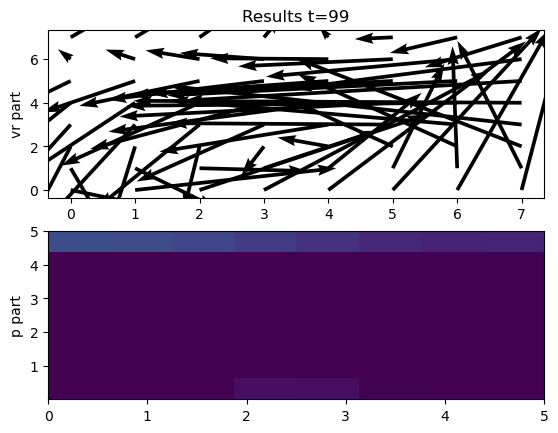

In [9]:

fig, ax = plt.subplots(2)

ax[0].set_ylabel("vr part")
vr_quiver = ax[0].quiver(
    np.arange(vr_predict.shape[1]),
    np.arange(vr_predict.shape[0]),
    vr_predict[:,:,0].T, 
    np.zeros_like(vr_predict[:,:,0].T),
    angles='xy', scale_units='xy', scale=1
)

ax[1].set_ylabel("p part")
p_plot = ax[1].imshow(
    p_predict[:,:,0].T,
    interpolation="nearest",
    cmap="viridis",
    extent=[0, t_max, r_min, r_max],
    origin="lower",
    aspect="auto"
)
multiplier = 50
def animate(t_curr):
    ax[0].set_title(f"Results t={t_curr}")
    vr_quiver.set_UVC(multiplier * vr_predict[:,:,t_curr].T, multiplier * vz_predict[:,:,t_curr].T)
    p_plot.set_array(p_predict[:,:,t_curr].T)
    return vr_quiver, p_plot

t_curr = 0
ani = FuncAnimation(fig, animate, frames=len(vr_predict[0,0,:]), interval=100, blit=True)

ani.save("animation.gif", writer="imagemagick", fps=10)

plt.show()